__In this notebook I want to train a model for each stations cluster__ (defined in clsutering_the_stations.ipynb).  
Preprocessing pipelines are defined in another file, if I want to improve the models later.

In [10]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib
import pickle

from termcolor import colored
from velib_prediction.pipeline import load_clean_hist, build_pipe
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = load_clean_hist()
df.head()

/Users/sebastienvallin/.pyenv/versions/3.8.12/envs/sebenv/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,station_id,time,capacity,temp2m,probarain,weather,wind10m,cluster,docks_available
0,213688169,2022-03-19 17:26:50,35,15.0,0.0,0.0,26.0,555.0,31
1,516709288,2022-03-19 17:26:50,20,15.0,0.0,0.0,26.0,7.0,19
2,36255,2022-03-19 17:26:50,21,15.0,0.0,0.0,26.0,888.0,14
3,37815204,2022-03-19 17:26:50,30,15.0,0.0,0.0,26.0,33.0,22
4,100769544,2022-03-19 17:26:50,45,15.0,0.0,0.0,26.0,8.0,0


Let's try a model on the smallest cluster first

In [3]:
def create_time_feature(df): #To use when creating X_train
    df['time'] = pd.to_datetime(df['time'])
    df['month'] = df['time'].dt.month
    df['hour'] = df['time'].dt.hour
    df['day'] = df['time'].dt.dayofweek
    df['minute'] = df['time'].dt.minute

    return df.drop(columns=['time'])

# Model tuning 

Trying on cluster n°1 here

In [4]:
X = df.query('cluster == 1')
y = X.pop('docks_available')

X = create_time_feature(X)

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8)

In [6]:
dmatrix = xgb.DMatrix(data=X, label=y)

params_1=  { 'objective':'reg:squarederror',
             'max_depth': 7, 
             'colsample_bylevel':0.6,
             'learning_rate':0.3,
             'random_state':20
           }

cv_results_1 = xgb.cv(dtrain=dmatrix, 
                    params=params_1, 
                    nfold=5, 
                    as_pandas=True,
                    metrics={'rmse'},
                    num_boost_round=10_000, 
                    verbose_eval=5,
                    early_stopping_rounds=5,
                    seed=20)

[0]	train-rmse:26.90895+0.01073	test-rmse:26.92451+0.06226
[5]	train-rmse:13.93290+0.13555	test-rmse:14.03291+0.16912
[10]	train-rmse:11.65243+0.18139	test-rmse:11.79409+0.18049
[15]	train-rmse:10.54775+0.17207	test-rmse:10.73312+0.19283
[20]	train-rmse:9.77775+0.18847	test-rmse:9.99630+0.21657
[25]	train-rmse:9.18603+0.13801	test-rmse:9.43014+0.14052
[30]	train-rmse:8.70008+0.16046	test-rmse:8.97917+0.15535
[35]	train-rmse:8.25545+0.13557	test-rmse:8.56355+0.12684
[40]	train-rmse:7.88701+0.08191	test-rmse:8.21640+0.08462
[45]	train-rmse:7.57414+0.06566	test-rmse:7.92771+0.07978
[50]	train-rmse:7.30390+0.06378	test-rmse:7.67348+0.04040
[55]	train-rmse:7.04033+0.06745	test-rmse:7.43320+0.07195
[60]	train-rmse:6.80258+0.06861	test-rmse:7.21190+0.08585
[65]	train-rmse:6.59845+0.05700	test-rmse:7.02367+0.06928
[70]	train-rmse:6.40387+0.03255	test-rmse:6.84022+0.05233
[75]	train-rmse:6.24396+0.02736	test-rmse:6.69642+0.06374
[80]	train-rmse:6.08636+0.02952	test-rmse:6.54708+0.08290
[85]	tra

[700]	train-rmse:2.24830+0.01649	test-rmse:3.45554+0.04234
[705]	train-rmse:2.24060+0.01596	test-rmse:3.45133+0.04272
[710]	train-rmse:2.23243+0.01588	test-rmse:3.44638+0.04558
[715]	train-rmse:2.22354+0.01568	test-rmse:3.44015+0.04551
[720]	train-rmse:2.21587+0.01372	test-rmse:3.43596+0.04551
[725]	train-rmse:2.20718+0.01372	test-rmse:3.43097+0.04578
[730]	train-rmse:2.20037+0.01367	test-rmse:3.42698+0.04555
[735]	train-rmse:2.19268+0.01336	test-rmse:3.42287+0.04540
[740]	train-rmse:2.18635+0.01405	test-rmse:3.41938+0.04451
[745]	train-rmse:2.17753+0.01369	test-rmse:3.41344+0.04263
[750]	train-rmse:2.17088+0.01423	test-rmse:3.40971+0.04344
[755]	train-rmse:2.16362+0.01586	test-rmse:3.40510+0.04337
[760]	train-rmse:2.15639+0.01788	test-rmse:3.40152+0.04384
[765]	train-rmse:2.14960+0.01846	test-rmse:3.39852+0.04363
[770]	train-rmse:2.14247+0.01776	test-rmse:3.39468+0.04354
[775]	train-rmse:2.13579+0.01737	test-rmse:3.39098+0.04387
[780]	train-rmse:2.12905+0.01705	test-rmse:3.38692+0.044

[1390]	train-rmse:1.53947+0.01129	test-rmse:3.08300+0.03521
[1395]	train-rmse:1.53616+0.01095	test-rmse:3.08157+0.03569
[1400]	train-rmse:1.53283+0.01035	test-rmse:3.07981+0.03548
[1405]	train-rmse:1.52963+0.01021	test-rmse:3.07864+0.03588
[1410]	train-rmse:1.52680+0.01012	test-rmse:3.07755+0.03629
[1415]	train-rmse:1.52348+0.01045	test-rmse:3.07590+0.03683
[1420]	train-rmse:1.52003+0.01024	test-rmse:3.07432+0.03653
[1425]	train-rmse:1.51733+0.01015	test-rmse:3.07329+0.03608
[1430]	train-rmse:1.51417+0.00970	test-rmse:3.07170+0.03567
[1435]	train-rmse:1.51072+0.00915	test-rmse:3.07012+0.03592
[1440]	train-rmse:1.50775+0.00856	test-rmse:3.06887+0.03638
[1445]	train-rmse:1.50487+0.00836	test-rmse:3.06835+0.03617
[1450]	train-rmse:1.50155+0.00832	test-rmse:3.06709+0.03593
[1455]	train-rmse:1.49860+0.00880	test-rmse:3.06588+0.03607
[1460]	train-rmse:1.49563+0.00848	test-rmse:3.06482+0.03602
[1465]	train-rmse:1.49318+0.00852	test-rmse:3.06417+0.03598
[1470]	train-rmse:1.49021+0.00826	test-r

[2075]	train-rmse:1.20937+0.00836	test-rmse:2.95780+0.03616
[2080]	train-rmse:1.20754+0.00836	test-rmse:2.95725+0.03621
[2085]	train-rmse:1.20560+0.00841	test-rmse:2.95674+0.03584
[2090]	train-rmse:1.20383+0.00864	test-rmse:2.95606+0.03559
[2095]	train-rmse:1.20190+0.00882	test-rmse:2.95538+0.03550
[2100]	train-rmse:1.19996+0.00862	test-rmse:2.95472+0.03542
[2105]	train-rmse:1.19809+0.00844	test-rmse:2.95429+0.03568
[2110]	train-rmse:1.19624+0.00846	test-rmse:2.95384+0.03554
[2115]	train-rmse:1.19445+0.00841	test-rmse:2.95339+0.03548
[2120]	train-rmse:1.19279+0.00875	test-rmse:2.95286+0.03576
[2125]	train-rmse:1.19087+0.00848	test-rmse:2.95219+0.03593
[2130]	train-rmse:1.18896+0.00871	test-rmse:2.95163+0.03586
[2135]	train-rmse:1.18703+0.00874	test-rmse:2.95105+0.03575
[2140]	train-rmse:1.18549+0.00853	test-rmse:2.95047+0.03566
[2145]	train-rmse:1.18367+0.00823	test-rmse:2.94988+0.03541
[2150]	train-rmse:1.18180+0.00788	test-rmse:2.94919+0.03567
[2155]	train-rmse:1.17998+0.00796	test-r

[2760]	train-rmse:1.00092+0.00437	test-rmse:2.90096+0.03328
[2765]	train-rmse:0.99953+0.00422	test-rmse:2.90068+0.03312
[2770]	train-rmse:0.99837+0.00426	test-rmse:2.90031+0.03314
[2775]	train-rmse:0.99696+0.00409	test-rmse:2.90006+0.03312
[2780]	train-rmse:0.99594+0.00417	test-rmse:2.89974+0.03309
[2785]	train-rmse:0.99469+0.00407	test-rmse:2.89935+0.03313
[2790]	train-rmse:0.99332+0.00421	test-rmse:2.89890+0.03298
[2795]	train-rmse:0.99201+0.00410	test-rmse:2.89854+0.03297
[2800]	train-rmse:0.99045+0.00385	test-rmse:2.89818+0.03283
[2805]	train-rmse:0.98908+0.00391	test-rmse:2.89783+0.03274
[2810]	train-rmse:0.98789+0.00382	test-rmse:2.89755+0.03270
[2815]	train-rmse:0.98658+0.00388	test-rmse:2.89721+0.03272
[2820]	train-rmse:0.98532+0.00373	test-rmse:2.89659+0.03253
[2825]	train-rmse:0.98417+0.00378	test-rmse:2.89636+0.03245
[2830]	train-rmse:0.98309+0.00373	test-rmse:2.89626+0.03234
[2835]	train-rmse:0.98204+0.00370	test-rmse:2.89593+0.03235
[2840]	train-rmse:0.98075+0.00374	test-r

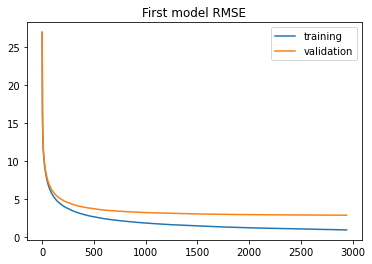

In [7]:
training_error_1 = cv_results_1['train-rmse-mean']
valid_error_1 = cv_results_1['test-rmse-mean']
x_axis = list(range(0,len(training_error_1)))

plt.title('First model RMSE')
plt.plot(x_axis,training_error_1, label='training')
plt.plot(x_axis,valid_error_1, label='validation')
plt.legend(loc="upper right");

As the computation is slow and I never missed the local minimum even with a bigger learning rate, I'll use 0.3 here.   
I managed to overfit with `max_depth`=8, which is a good thing, so I augmented the bias with `colsample_bylevel`= 0.6 and `max_depth`=7.  We got nice performances with it, let's train a model for each cluster

I'll implement the pipelines in a .py file 

# Train and export pipelines

In [11]:
def train_one_model(cluster, n_estimators=3_000):
    
    print('\n')
    print(colored('='*50,'blue'))
    print(f"Fitting cluster n° {cluster}")
    
    X = df.query(f'cluster == {cluster}').drop(columns='cluster')
    y = X.pop('docks_available')

    X = create_time_feature(X)
    X.columns = ['station_id', 'capacity', 'temp2m', 'probarain', 'weather', 'wind10m',
                 'month', 'hour', 'day', 'minute']

    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8)
    
    pipe = build_pipe(n_estimators)
    
    pipe.fit(X_train,y_train)
    
    ypred = pipe.predict(X_test)
    mse = mean_squared_error(y_test, ypred)
    print("RMSE: %.2f" % (mse**(1/2.0)))
    
    return pipe # Fitted !

In [12]:
for i in df.cluster.unique():

    # Export pipeline as pickle file
    with open(f"docks_cl_{int(i)}.pkl", "wb") as file:
        pickle.dump(train_one_model(i), file)






Fitting cluster n° 555.0
RMSE: 1.48


Fitting cluster n° 7.0
RMSE: 1.40


Fitting cluster n° 888.0
RMSE: 1.22


Fitting cluster n° 33.0
RMSE: 1.88


Fitting cluster n° 8.0
RMSE: 2.14


Fitting cluster n° 3.0
RMSE: 2.19


Fitting cluster n° 88.0
RMSE: 1.28


Fitting cluster n° 4.0
RMSE: 1.76


Fitting cluster n° 1.0
RMSE: 2.65


Fitting cluster n° 55.0
RMSE: 1.57


Fitting cluster n° 0.0
RMSE: 1.53


Fitting cluster n° 2.0
RMSE: 1.89


Fitting cluster n° 6.0
RMSE: 2.08


Fitting cluster n° 11.0
RMSE: 1.57
